# Facial Feature Extraction and Audio Processing Pipeline

# 1. Facial Feature Extraction and Analysis

## Overview
The first part of this notebook implements a complete pipeline for facial feature extraction and analysis.

## Key Features
- Face detection and landmark identification
- Image augmentation (rotation, flipping, grayscale, noise)
- Facial feature extraction
- Feature visualization and analysis
- CSV export of extracted features

### 1.1 Required Libraries

In [11]:
import os
import cv2
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from imgaug import augmenters as iaa
from imutils import face_utils

import warnings
warnings.filterwarnings("ignore")


os.makedirs('output/augmented_images', exist_ok=True)
os.makedirs('images', exist_ok=True)

print("Directories set up successfully!")

Directories set up successfully!


### 1.2  Helper Functions

In [28]:
def setup_image_augmentations():
    """Create augmentation sequences for images"""
    return {
        'original': None,
        'rotated': iaa.Sequential([iaa.Affine(rotate=(-25, 25))]),
        'flipped': iaa.Sequential([iaa.Fliplr(1.0)]),
        'grayscale': iaa.Sequential([iaa.Grayscale(alpha=1.0)]),
        'noisy': iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(10, 30))])
    }

def detect_face_landmarks(image, detector, predictor):
    """Detect facial landmarks using dlib"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)
    if len(faces) == 0:
        return None
    shape = predictor(gray, faces[0])
    return face_utils.shape_to_np(shape)

def extract_face_features(face_image, landmarks):
    """Extract facial features including measurements but without face encodings"""

    # Calculate face aspect ratio
    (x, y, w, h) = cv2.boundingRect(landmarks)
    aspect_ratio = float(w) / h

    # Calculate eye aspect ratio
    left_eye = landmarks[36:42]
    right_eye = landmarks[42:48]

    def eye_aspect_ratio(eye):
        A = np.linalg.norm(eye[1] - eye[5])
        B = np.linalg.norm(eye[2] - eye[4])
        C = np.linalg.norm(eye[0] - eye[3])
        return (A + B) / (2.0 * C)

    ear = (eye_aspect_ratio(left_eye) + eye_aspect_ratio(right_eye)) / 2.0

    return {
        'face_aspect_ratio': aspect_ratio,
        'eye_aspect_ratio': ear,
        'landmarks': landmarks.tolist()
    }

### 1.3 Process the Images

In [26]:
def process_my_images():
    """Process your images with visual feedback"""
    input_dir = 'images'
    output_dir = 'output/augmented_images'

    # Initialize face detector and predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    # Get all image files
    image_files = [f for f in os.listdir(input_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No images found in {input_dir}. Please add your images to the 'images' folder.")
        print("Expected files: neutral.jpg, smiling.jpg, surprised.jpg")
        return None

    all_features = []
    augmentations = setup_image_augmentations()

    for img_file in tqdm(image_files, desc="Processing your images"):
        img_path = os.path.join(input_dir, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Could not read image: {img_path}")
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        landmarks = detect_face_landmarks(img, detector, predictor)

        if landmarks is None:
            print(f"No face detected in {img_file}")
            continue

        # Display and process original image
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 3, 1)
        plt.imshow(img_rgb)
        plt.title(f"Original: {img_file}")
        plt.axis('off')

        # Extract features from original
        features = extract_face_features(img_rgb, landmarks)
        if features:
            features.update({
                'image_file': img_file,
                'augmentation': 'original'
            })
            all_features.append(features)

        # Apply each augmentation
        for i, (aug_name, aug) in enumerate(augmentations.items(), 2):
            if aug is None:
                continue

            aug_img = aug.augment_image(img)
            aug_img_rgb = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
            aug_landmarks = detect_face_landmarks(aug_img, detector, predictor)

            if aug_landmarks is None:
                continue

            plt.subplot(2, 3, i)
            plt.imshow(aug_img_rgb)
            plt.title(f"{aug_name}")
            plt.axis('off')

            # Save augmented image
            aug_filename = f"{os.path.splitext(img_file)[0]}_{aug_name}.jpg"
            aug_path = os.path.join(output_dir, aug_filename)
            cv2.imwrite(aug_path, aug_img)

            # Extract features from augmented image
            aug_features = extract_face_features(aug_img_rgb, aug_landmarks)
            if aug_features:
                aug_features.update({
                    'image_file': aug_filename,
                    'augmentation': aug_name
                })
                all_features.append(aug_features)

        plt.tight_layout()
        plt.show()

    return all_features

### 1.4 Save and Display Results

Starting image processing...


Processing your images:   0%|          | 0/3 [00:00<?, ?it/s]

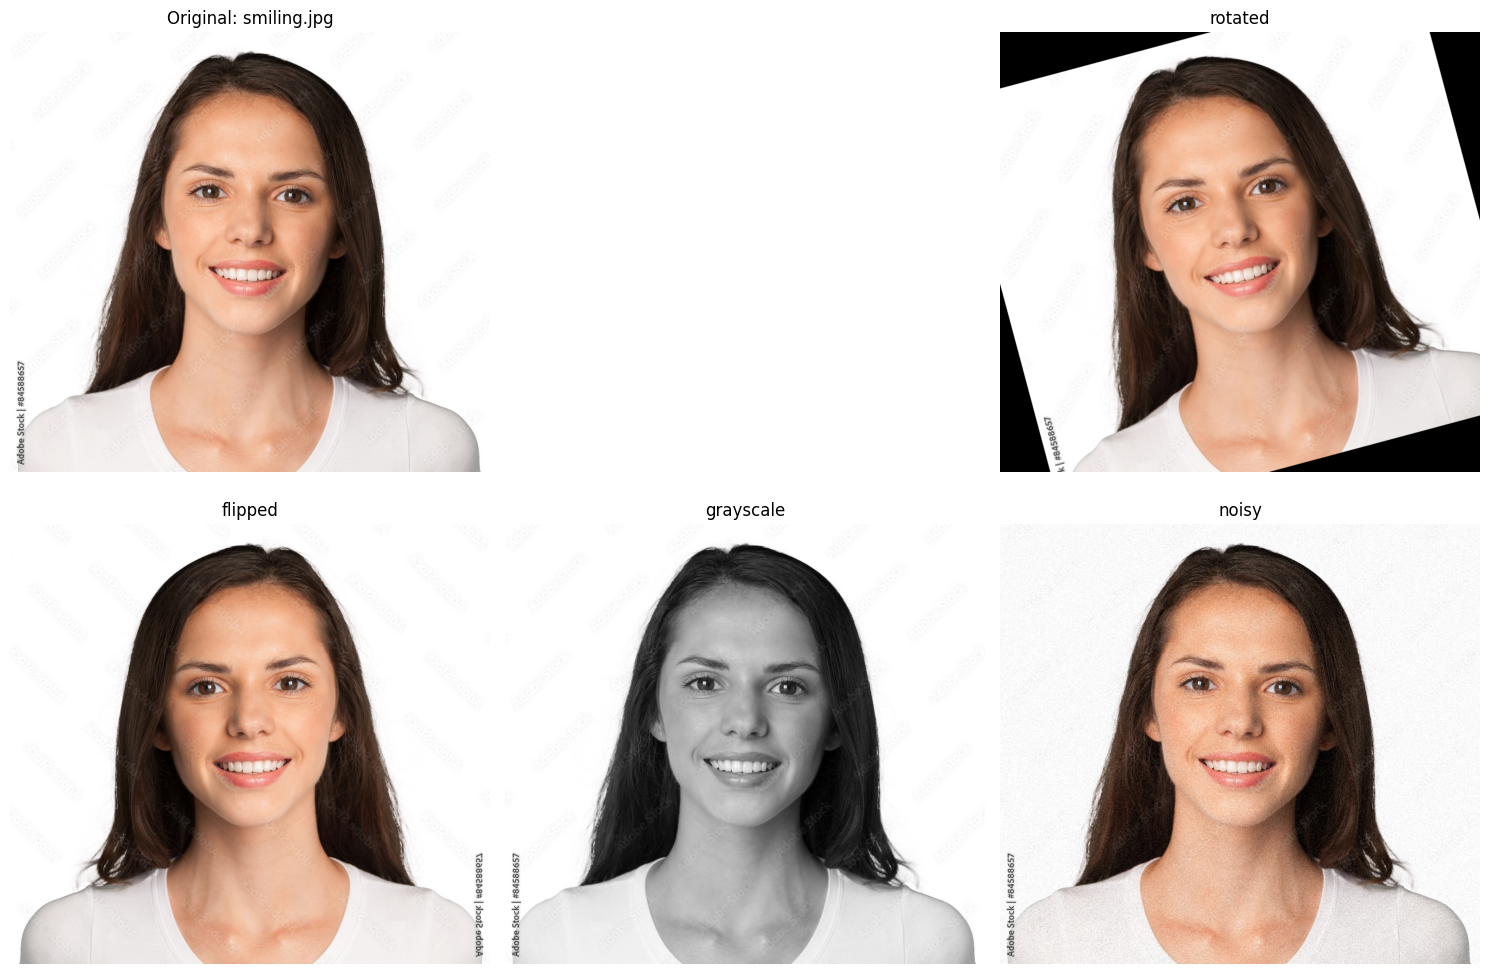

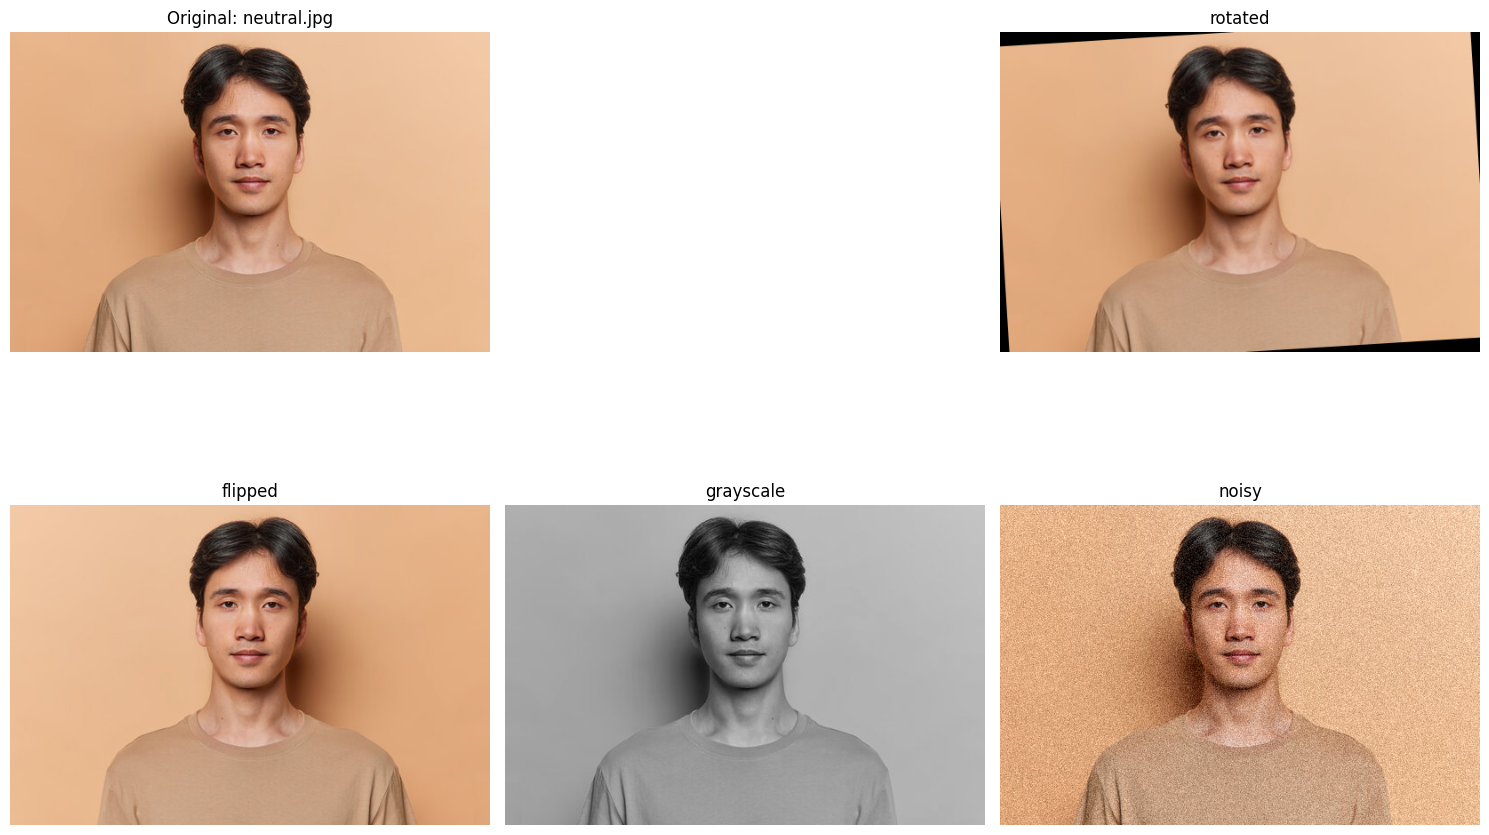

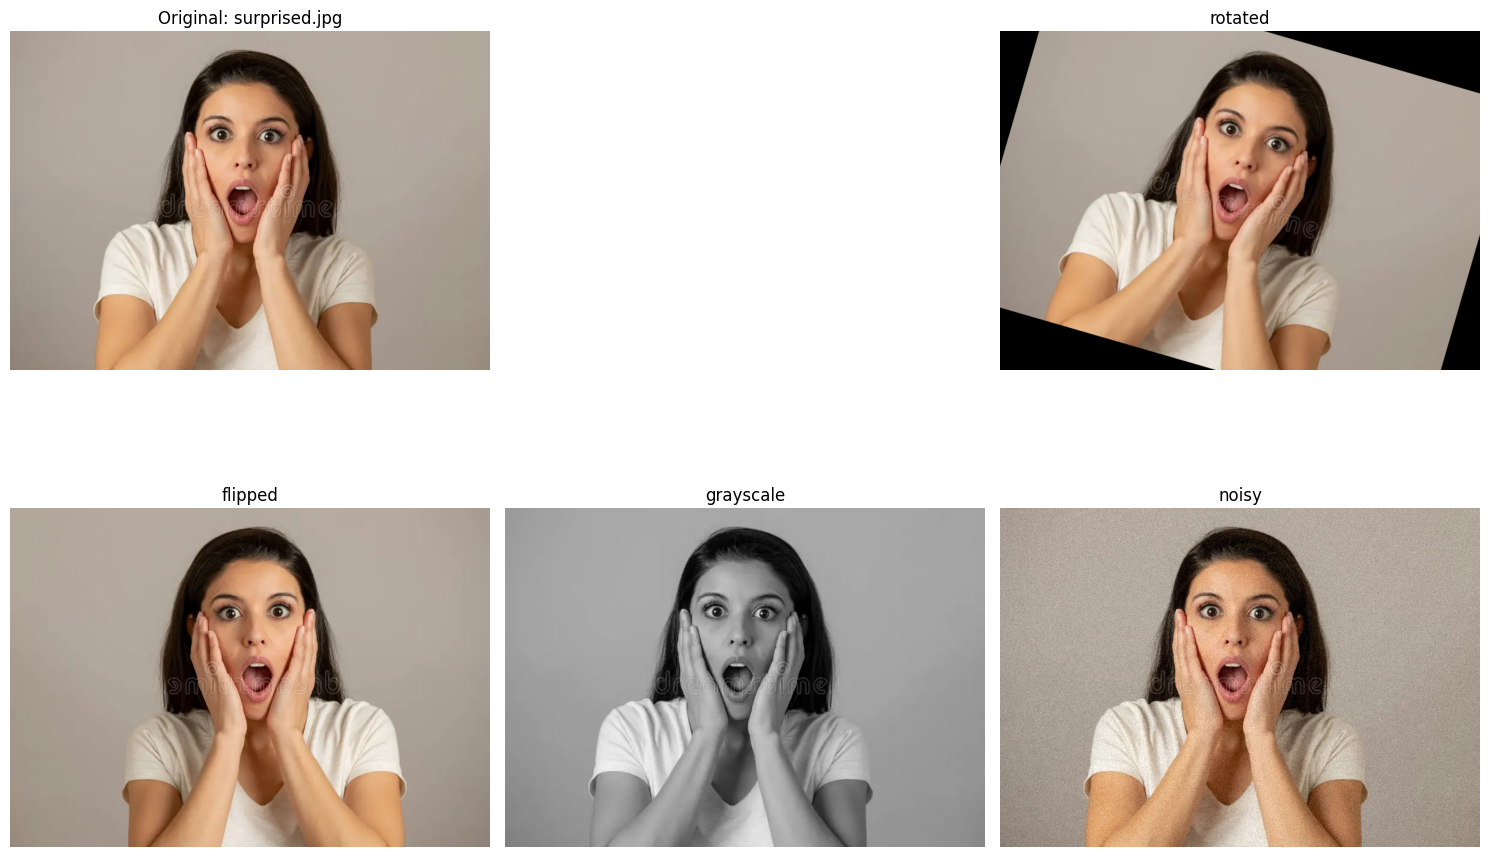


Features saved to image_features.csv

Extracted features for 15 images.

Sample of extracted features:


,image_file,augmentation,face_aspect_ratio,eye_aspect_ratio
0,smiling.jpg,original,1.033708,0.326747
1,smiling_rotated.jpg,rotated,1.000000,0.333310
2,smiling_flipped.jpg,flipped,1.028090,0.316569
3,smiling_grayscale.jpg,grayscale,1.025000,0.336272
4,smiling_noisy.jpg,noisy,1.016484,0.333237


In [25]:
def save_my_features(features_list, output_file='image_features.csv'):
    """Save your extracted features to CSV"""
    if not features_list:
        print("No features to save")
        return None

    flattened = []
    for feature_set in features_list:
        flat = {
            'image_file': feature_set['image_file'],
            'augmentation': feature_set['augmentation'],
            'face_aspect_ratio': feature_set['face_aspect_ratio'],
            'eye_aspect_ratio': feature_set['eye_aspect_ratio'],
        }

        # face_encoding was removed, so no need to add encoding dimensions

        flattened.append(flat)

    # Create DataFrame and save to CSV
    df = pd.DataFrame(flattened)
    df.to_csv(output_file, index=False)
    print(f"\nFeatures saved to {output_file}")
    print(f"\nExtracted features for {len(df)} images.")
    print("\nSample of extracted features:")
    return df.head()

# Run the processing
print("Starting image processing...")
my_features = process_my_images()

if my_features:
    features_df = save_my_features(my_features)
    display(features_df)
else:
    print("No features were extracted. Please check your images in the 'images' folder.")

### 1.6. VIsualization

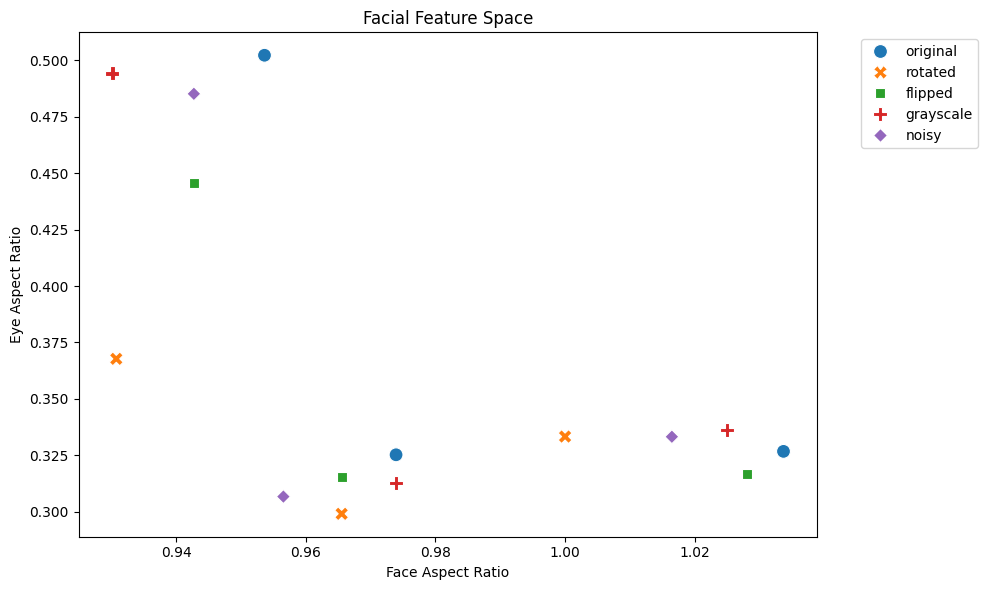

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='face_aspect_ratio', y='eye_aspect_ratio',
                hue='augmentation', style='augmentation', s=100)
plt.title('Facial Feature Space')
plt.xlabel('Face Aspect Ratio')
plt.ylabel('Eye Aspect Ratio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Audio Processing Pipeline

## Overview
The second part of this notebook implements a complete audio processing pipeline for voice command analysis.

## Key Features
- Audio loading and visualization
- Feature extraction (MFCCs, spectral features, etc.)
- Audio augmentation
- Feature storage and analysis

### 2.1 Import Required Libraries

In [33]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm.notebook import tqdm
import noisereduce as nr
import random

# Set up directories
os.makedirs('audio_samples', exist_ok=True)
os.makedirs('output/augmented_audio', exist_ok=True)

print(" Audio processing setup complete!")

 Audio processing setup complete!


### 2.2 Core Audio Processing Functions

In [42]:
def load_audio(file_path, target_sr=22050):
    """Load and resample audio file"""
    y, sr = librosa.load(file_path, sr=target_sr)
    return y, sr

def plot_waveform(y, sr, title="Waveform"):
    """Plot audio waveform"""
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def plot_spectrogram(y, sr, title="Spectrogram"):
    """Plot audio spectrogram"""
    plt.figure(figsize=(12, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

### 2.3 Feature Extraction

In [43]:
def extract_audio_features(y, sr, n_mfcc=13):
    """Extract audio features including MFCCs and spectral features"""
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    return {
        'mfcc_mean': np.mean(mfccs, axis=1).tolist(),
        'spectral_centroid_mean': float(np.mean(spectral_centroid)),
        'spectral_bandwidth_mean': float(np.mean(spectral_bandwidth)),
        'spectral_rolloff_mean': float(np.mean(spectral_rolloff)),
        'zcr_mean': float(np.mean(zcr)),
        'rms_mean': float(np.mean(rms)),
        'chroma_mean': np.mean(chroma, axis=1).tolist()
    }

### 2.4 Audio Augmentations

In [44]:
def apply_time_stretch(y, rate=1.2):
    """Apply time stretching to audio"""
    return librosa.effects.time_stretch(y, rate=rate)

def apply_pitch_shift(y, sr, n_steps=2):
    """Apply pitch shifting to audio"""
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_background_noise(y, noise_level=0.005):
    """Add random background noise to audio"""
    noise = np.random.randn(len(y))
    return y + noise_level * noise

def save_audio(y, sr, filename):
    """Save audio to file"""
    sf.write(filename, y, sr)
    return filename

### 2.5 Process Single Audio File

In [45]:
def process_audio_file(file_path, output_dir, sample_name, sr=22050):
    """Process a single audio file with augmentations"""
    y, sr = load_audio(file_path, sr)
    results = []

    # Original audio
    features = extract_audio_features(y, sr)
    results.append({
        'sample_name': sample_name,
        'augmentation': 'original',
        'duration_seconds': len(y)/sr,
        **features
    })

    # Apply augmentations
    augmentations = {
        'time_stretched': apply_time_stretch(y),
        'pitch_shifted': apply_pitch_shift(y, sr),
        'with_noise': add_background_noise(y)
    }

    # Process each augmentation
    for aug_name, aug_y in augmentations.items():
        min_len = min(len(y), len(aug_y))
        aug_y = aug_y[:min_len]

        # Save augmented audio
        aug_filename = f"{os.path.splitext(os.path.basename(file_path))[0]}_{aug_name}.wav"
        aug_path = os.path.join(output_dir, aug_filename)
        save_audio(aug_y, sr, aug_path)

        # Extract features
        features = extract_audio_features(aug_y, sr)
        results.append({
            'sample_name': sample_name,
            'augmentation': aug_name,
            'duration_seconds': len(aug_y)/sr,
            **features
        })

    return results

### 2.6 Process All Audio Files

In [46]:

def process_all_audio(input_dir='audio_samples', output_dir='output/augmented_audio'):
    """Process all audio files in the input directory"""
    all_features = []
    expected_files = ['approve.wav.unknown', 'confirm.wav.unknown']

    for file in expected_files:
        file_path = os.path.join(input_dir, file)
        if os.path.exists(file_path):
            sample_name = os.path.splitext(file)[0]
            print(f"\n Processing {sample_name}...")

            # Display original audio
            y, sr = load_audio(file_path)
            plot_waveform(y, sr, f"Waveform: {sample_name}")
            plot_spectrogram(y, sr, f"Spectrogram: {sample_name}")

            # Process with augmentations
            features = process_audio_file(file_path, output_dir, sample_name, sr)
            all_features.extend(features)
        else:
            print(f" Warning: {file} not found in {input_dir}")

    return all_features

### 2.7 Save Features to CSV

In [47]:
def save_audio_features(features, output_file='audio_features.csv'):
    """Save extracted audio features to CSV"""
    if not features:
        print(" No features to save")
        return None

    df = pd.DataFrame(features)

    # Flatten MFCC and chroma features
    mfcc_cols = [f'mfcc_{i}' for i in range(13)]
    chroma_cols = [f'chroma_{i}' for i in range(12)]

    mfcc_df = pd.DataFrame(df['mfcc_mean'].tolist(), columns=mfcc_cols)
    chroma_df = pd.DataFrame(df['chroma_mean'].tolist(), columns=chroma_cols)

    # Combine all features
    final_df = pd.concat([
        df[['sample_name', 'augmentation', 'duration_seconds',
            'spectral_centroid_mean', 'spectral_bandwidth_mean',
            'spectral_rolloff_mean', 'zcr_mean', 'rms_mean']],
        mfcc_df,
        chroma_df
    ], axis=1)

    # Save to CSV
    final_df.to_csv(output_file, index=False)
    print(f"\n All audio features saved to {output_file}")
    return final_df

### 2.8 Main Execution

 Starting audio processing...

 Processing approve.wav...


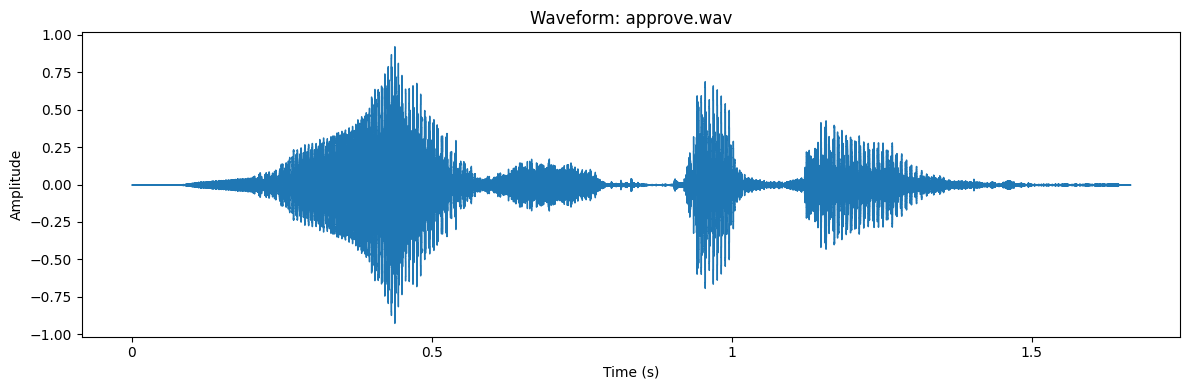

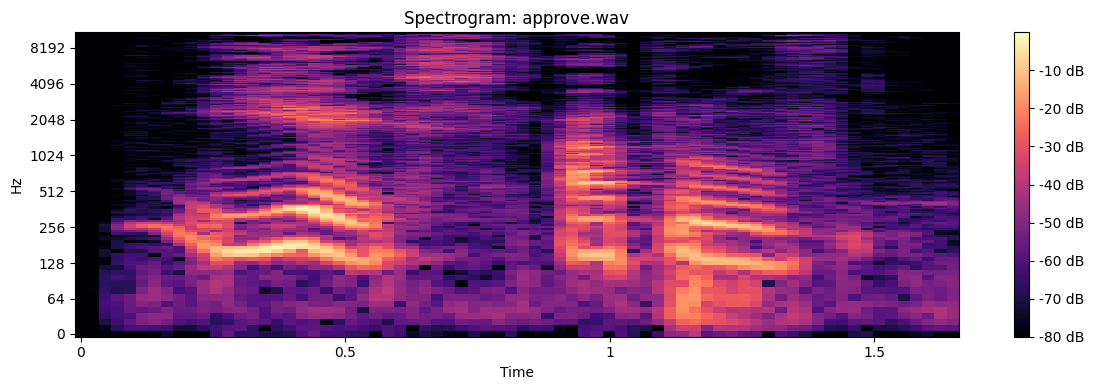


 Processing confirm.wav...


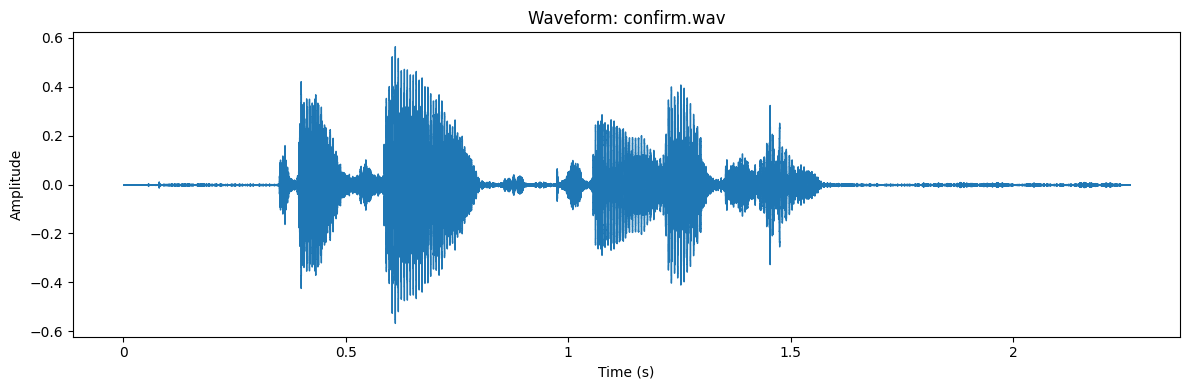

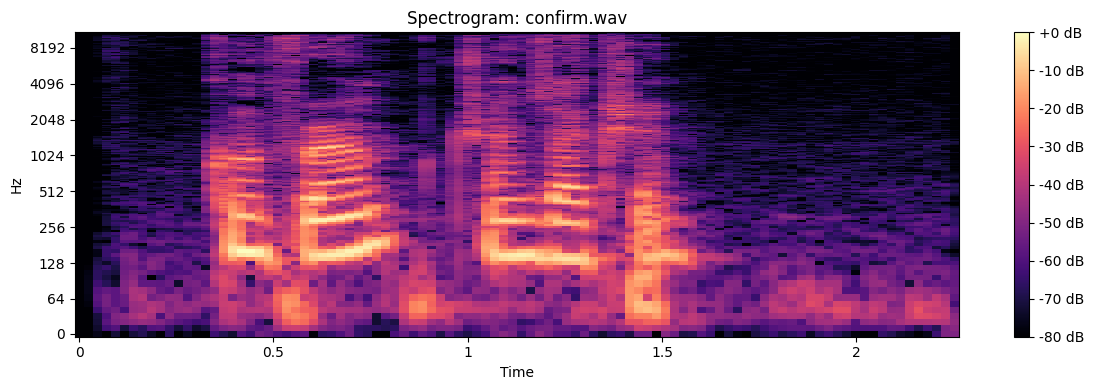


 All audio features saved to audio_features.csv

 Sample of extracted audio features:


,sample_name,augmentation,duration_seconds,spectral_centroid_mean,spectral_bandwidth_mean,spectral_rolloff_mean,zcr_mean,rms_mean,mfcc_0,mfcc_1,...,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11
0,approve.wav,original,1.664036,2726.834374,2592.579178,5400.796509,0.140930,0.083447,-289.165894,72.568565,...,0.502292,0.396107,0.328755,0.305816,0.285594,0.324695,0.351091,0.292781,0.271802,0.353391
1,approve.wav,time_stretched,1.386712,2624.361748,2569.457118,5255.537109,0.141512,0.062386,-308.913971,74.789299,...,0.485592,0.460733,0.319531,0.274379,0.309489,0.256257,0.262489,0.282658,0.240531,0.257261
2,approve.wav,pitch_shifted,1.664036,2710.752592,2596.794771,5376.571655,0.149651,0.058634,-310.566315,75.501183,...,0.323732,0.384762,0.422785,0.425490,0.330009,0.279784,0.275034,0.226229,0.271661,0.283995
3,approve.wav,with_noise,1.664036,3646.087677,2960.825250,7011.450195,0.224033,0.084228,-221.521500,43.424083,...,0.543896,0.520315,0.415963,0.364856,0.348343,0.310156,0.347399,0.362347,0.336505,0.339997
4,confirm.wav,original,2.261361,2617.082818,2907.744466,5945.581055,0.099470,0.046132,-357.193451,85.173576,...,0.677470,0.650266,0.541567,0.439189,0.428768,0.454989,0.495461,0.522417,0.460007,0.439629


In [48]:
print(" Starting audio processing...")
all_audio_features = process_all_audio()

if all_audio_features:
    audio_features_df = save_audio_features(all_audio_features)
    print("\n Sample of extracted audio features:")
    display(audio_features_df.head())
else:
    print(" No audio features were extracted. Please check your audio files.")